<a href="https://colab.research.google.com/github/anantoj/covid19-xray-detection/blob/main/notebooks/ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ResNet50

In [ ]:
!pip install -Uq tensorflow==2.4

     |████████████████████████████████| 394.7MB 40kB/s 
     |████████████████████████████████| 2.9MB 51.6MB/s 
     |████████████████████████████████| 471kB 50.7MB/s 
     |████████████████████████████████| 3.8MB 44.1MB/s 


In [ ]:
!unzip -q /content/drive/MyDrive/dataset2.zip

In [ ]:
import os
import random
import shutil
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,TensorBoard,LearningRateScheduler
from datetime import datetime
import matplotlib.pyplot as plt

In [ ]:
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.0001
NUM_CLASSES = 2
SPLIT = 0.2
SEED = 42

In [ ]:
random.seed(SEED)
os.chdir('/content/dataset2')
if os.path.isdir('/content/train/covid') is False:
    os.makedirs('/content/train/covid')
    os.makedirs('/content/train/normal')
    os.makedirs('/content/val/covid')
    os.makedirs('/content/val/normal')
    os.makedirs('/content/test/covid')
    os.makedirs('/content/test/normal')

    for c in random.sample(glob.glob('COVID*'), 2892):
        shutil.move(c, '/content/train/covid')
    for c in random.sample(glob.glob('COVID*'), 362):
        shutil.move(c, '/content/val/covid')
    for c in random.sample(glob.glob('COVID*'), 362):
        shutil.move(c, '/content/test/covid')
    for c in random.sample(glob.glob('Normal*'), 8154):
        shutil.move(c, '/content/train/normal')
    for c in random.sample(glob.glob('Normal*'), 1019):
        shutil.move(c, '/content/val/normal')
    for c in random.sample(glob.glob('Normal*'), 1019):
        shutil.move(c, '/content/test/normal')

os.chdir('../')


In [ ]:
train_path = '/content/train'
val_path = '/content/val'
test_path = '/content/test'

In [ ]:
datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    rotation_range = 10,
    horizontal_flip = True)

train_generator = datagen.flow_from_directory(
    train_path,
    target_size = (224, 224),
    batch_size = BATCH_SIZE,
    shuffle=True)

validation_generator = datagen.flow_from_directory(
    val_path,
    target_size = (224, 224),
    batch_size = BATCH_SIZE,
    shuffle=True)

test_generator = datagen.flow_from_directory(
    test_path,
    target_size = (224, 224),
    batch_size = BATCH_SIZE,
    shuffle=False)

Found 11046 images belonging to 2 classes.
Found 1381 images belonging to 2 classes.
Found 1381 images belonging to 2 classes.


In [ ]:
resnet = ResNet50(weights='imagenet', include_top=False)

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
model = Sequential()
model.add(resnet)
model.add(GlobalAveragePooling2D())
model.add(Dense(NUM_CLASSES, activation='sigmoid'))

In [ ]:
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=LEARNING_RATE),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 23,538,690
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
def scheduler(epoch, lr):
      if epoch < 5:
        return lr
      else:
        return lr * tf.math.exp(-0.1)

In [ ]:
log_dir='./logs/fit'+datetime.now().strftime('%d.%m.%Y--%H-%M-%S')
model_path='/content/resnet50.h5'
checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy',
                             verbose=1, save_best_only=True,
                             save_weights_only=False, mode='auto',
                             save_freq='epoch')
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10,verbose=1, mode='auto')
board=TensorBoard(log_dir=log_dir,histogram_freq=1)
dec=LearningRateScheduler(scheduler)
tensorboard_callback =[checkpoint,early,board,dec]

In [ ]:
hist = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator),
    callbacks=[tensorboard_callback]
)

Epoch 1/50
346/346 [==============================] - 214s 507ms/step - loss: 0.1875 - accuracy: 0.9229 - precision: 0.9311 - recall: 0.9015 - val_loss: 0.6739 - val_accuracy: 0.7364 - val_precision: 0.7316 - val_recall: 0.7422

Epoch 00001: val_accuracy improved from -inf to 0.73642, saving model to /content/resnet50.h5
Epoch 2/50
346/346 [==============================] - 170s 492ms/step - loss: 0.0627 - accuracy: 0.9784 - precision: 0.9786 - recall: 0.9782 - val_loss: 0.7721 - val_accuracy: 0.5025 - val_precision: 0.5084 - val_recall: 0.6329

Epoch 00002: val_accuracy did not improve from 0.73642
Epoch 3/50
346/346 [==============================] - 169s 488ms/step - loss: 0.0454 - accuracy: 0.9856 - precision: 0.9854 - recall: 0.9858 - val_loss: 1.0083 - val_accuracy: 0.5134 - val_precision: 0.5144 - val_recall: 0.4931

Epoch 00003: val_accuracy did not improve from 0.73642
Epoch 4/50
346/346 [==============================] - 169s 489ms/step - loss: 0.0343 - accuracy: 0.9870 - pre

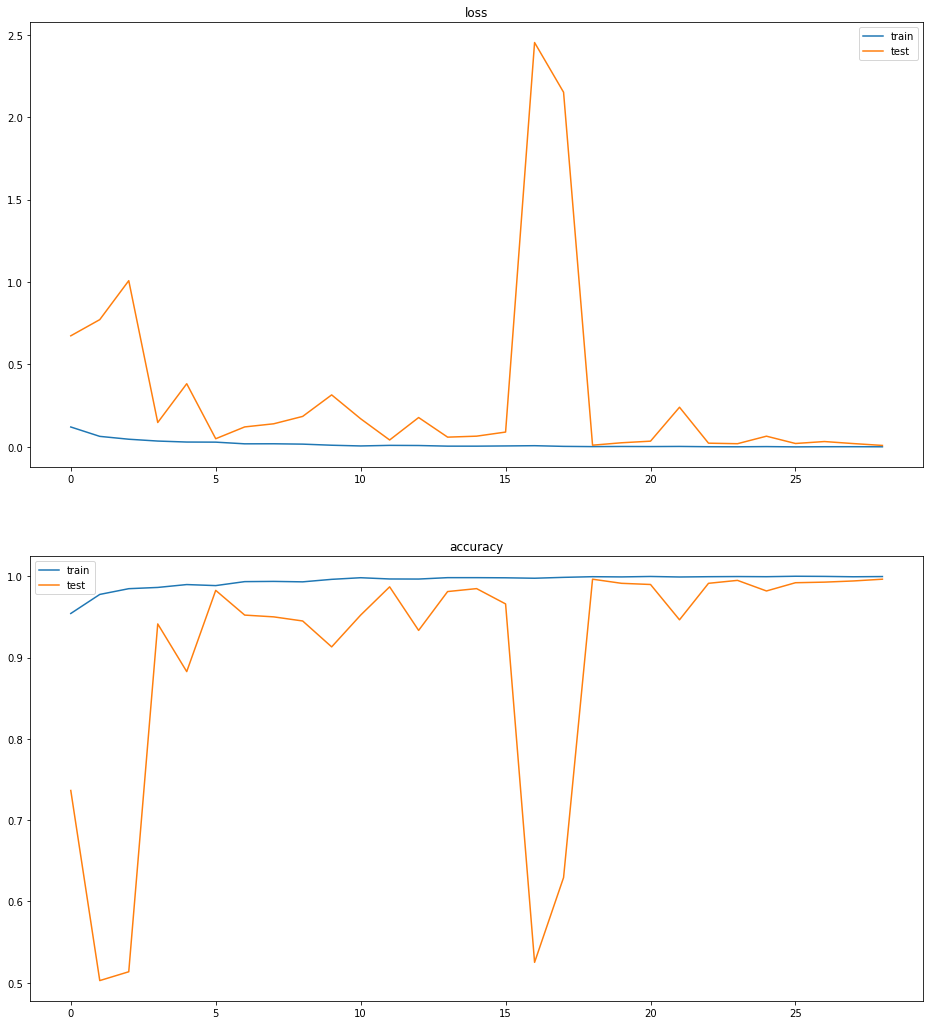

In [ ]:
plt.figure(1, figsize=(16,18))
plt.subplot(2,1,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['train','val'])
plt.title('loss')
plt.subplot(2,1,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['train','val'])
plt.title('accuracy')
plt.show()

In [ ]:
loss, acc, pre, rec = model.evaluate(test_generator)
print("\ntest %s: %.2f%%" % (model.metrics_names[1], acc * 100))
print("\ntest %s: %.2f%%" % (model.metrics_names[2], pre * 100))
print("\ntest %s: %.2f%%" % (model.metrics_names[3], rec * 100))

44/44 [==============================] - 16s 363ms/step - loss: 0.0307 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928

test accuracy: 99.28%

test precision: 99.28%

test recall: 99.28%


#ResNet101

In [ ]:
from tensorflow.keras.applications import ResNet101

In [ ]:
resnet101 = ResNet101(weights='imagenet', include_top=False)

171450368/171446536 [==============================] - 1s 0us/step


In [ ]:
resnet101_model = Sequential()
resnet101_model.add(resnet101)
resnet101_model.add(GlobalAveragePooling2D())
resnet101_model.add(Dense(NUM_CLASSES, activation='sigmoid'))

In [ ]:
resnet101_model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(lr=LEARNING_RATE),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [ ]:
resnet101_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101 (Functional)       (None, None, None, 2048)  42658176  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 4098      
Total params: 42,662,274
Trainable params: 42,556,930
Non-trainable params: 105,344
_________________________________________________________________


In [ ]:
log_dir='./logs/fit'+datetime.now().strftime('%d.%m.%Y--%H-%M-%S')
model_path='/content/resnet101.h5'
checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy',
                             verbose=1, save_best_only=True,
                             save_weights_only=False, mode='auto',
                             save_freq='epoch')
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10,verbose=1, mode='auto')
board=TensorBoard(log_dir=log_dir,histogram_freq=1)
dec=LearningRateScheduler(scheduler)
tensorboard_callback =[checkpoint,early,board,dec]

In [ ]:
hist = resnet101_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator),
    callbacks=[tensorboard_callback]
)

Epoch 1/50
346/346 [==============================] - 234s 649ms/step - loss: 0.1862 - accuracy: 0.9281 - precision_1: 0.9259 - recall_1: 0.9265 - val_loss: 2.0590 - val_accuracy: 0.2621 - val_precision_1: 0.2621 - val_recall_1: 0.2621

Epoch 00001: val_accuracy improved from -inf to 0.26213, saving model to /content/resnet101.h5
Epoch 2/50
346/346 [==============================] - 225s 650ms/step - loss: 0.0604 - accuracy: 0.9789 - precision_1: 0.9786 - recall_1: 0.9797 - val_loss: 2.4311 - val_accuracy: 0.2621 - val_precision_1: 0.2623 - val_recall_1: 0.2621

Epoch 00002: val_accuracy did not improve from 0.26213
Epoch 3/50
346/346 [==============================] - 225s 650ms/step - loss: 0.0541 - accuracy: 0.9804 - precision_1: 0.9809 - recall_1: 0.9803 - val_loss: 1.0631 - val_accuracy: 0.4909 - val_precision_1: 0.4926 - val_recall_1: 0.4830

Epoch 00003: val_accuracy improved from 0.26213 to 0.49095, saving model to /content/resnet101.h5
Epoch 4/50
346/346 [=====================

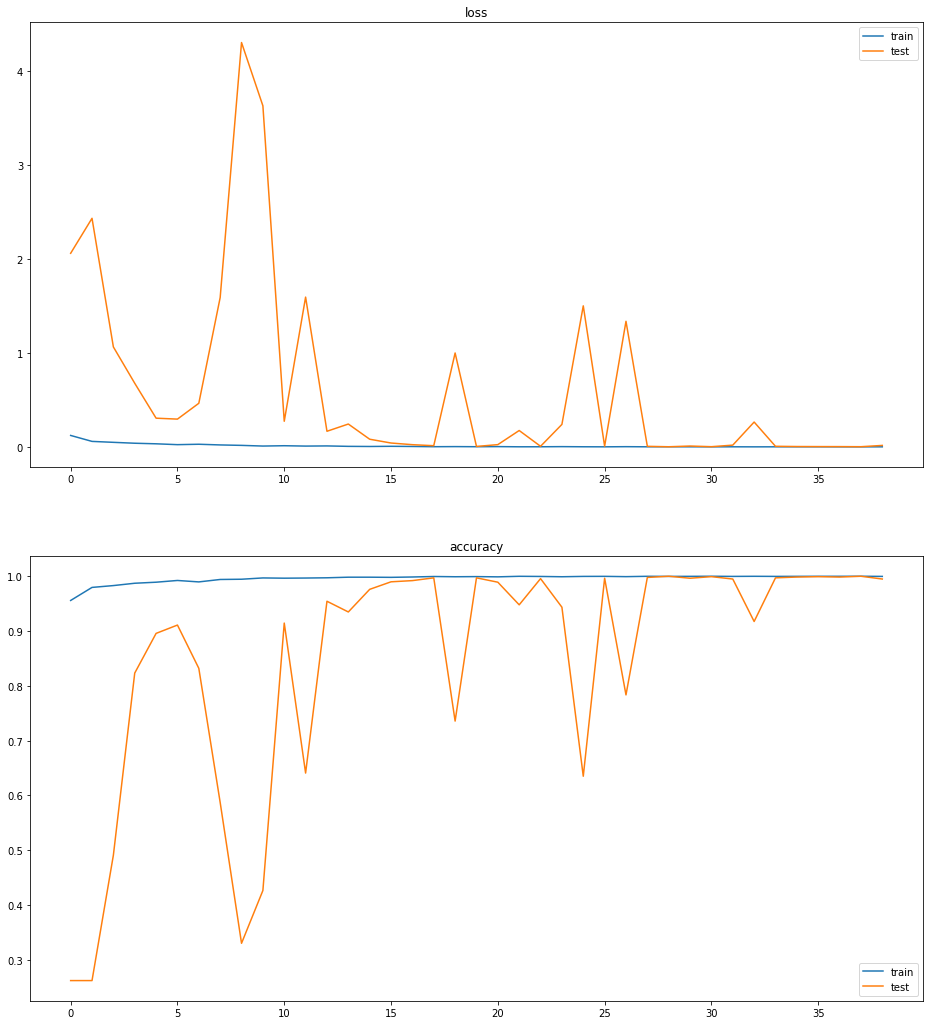

In [ ]:
plt.figure(1, figsize=(16,18))
plt.subplot(2,1,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['train','val'])
plt.title('loss')
plt.subplot(2,1,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['train','val'])
plt.title('accuracy')
plt.show()

In [ ]:
loss, acc, pre, rec = resnet101_model.evaluate(test_generator)
print("\ntest %s: %.2f%%" % (resnet101_model.metrics_names[1], acc * 100))
print("\ntest %s: %.2f%%" % (resnet101_model.metrics_names[2], pre * 100))
print("\ntest %s: %.2f%%" % (resnet101_model.metrics_names[3], rec * 100))

44/44 [==============================] - 18s 396ms/step - loss: 0.0317 - accuracy: 0.9906 - precision_1: 0.9906 - recall_1: 0.9906

test accuracy: 99.06%

test precision_1: 99.06%

test recall_1: 99.06%


#ResNet152

In [ ]:
from tensorflow.keras.applications import ResNet152

In [ ]:
resnet152 = ResNet152(weights='imagenet', include_top=False)

234700800/234698864 [==============================] - 3s 0us/step


In [ ]:
resnet152_model = Sequential()
resnet152_model.add(resnet152)
resnet152_model.add(GlobalAveragePooling2D())
resnet152_model.add(Dense(NUM_CLASSES, activation='sigmoid'))

In [ ]:
resnet152_model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(lr=LEARNING_RATE),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [ ]:
resnet152_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152 (Functional)       (None, None, None, 2048)  58370944  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 4098      
Total params: 58,375,042
Trainable params: 58,223,618
Non-trainable params: 151,424
_________________________________________________________________


In [ ]:
log_dir='./logs/fit'+datetime.now().strftime('%d.%m.%Y--%H-%M-%S')
model_path='/content/resnet152.h5'
checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy',
                             verbose=1, save_best_only=True,
                             save_weights_only=False, mode='auto',
                             save_freq='epoch')
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10,verbose=1, mode='auto')
board=TensorBoard(log_dir=log_dir,histogram_freq=1)
dec=LearningRateScheduler(scheduler)
tensorboard_callback =[checkpoint,early,board,dec]

In [ ]:
hist = resnet152_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator),
    callbacks=[tensorboard_callback]
)

Epoch 1/50
346/346 [==============================] - 336s 931ms/step - loss: 0.1815 - accuracy: 0.9287 - precision_2: 0.9254 - recall_2: 0.9276 - val_loss: 1.2885 - val_accuracy: 0.2629 - val_precision_2: 0.2597 - val_recall_2: 0.2563

Epoch 00001: val_accuracy improved from -inf to 0.26285, saving model to /content/resnet152.h5
Epoch 2/50
346/346 [==============================] - 316s 913ms/step - loss: 0.0715 - accuracy: 0.9768 - precision_2: 0.9761 - recall_2: 0.9767 - val_loss: 0.5748 - val_accuracy: 0.7371 - val_precision_2: 0.7250 - val_recall_2: 0.7466

Epoch 00002: val_accuracy improved from 0.26285 to 0.73715, saving model to /content/resnet152.h5
Epoch 3/50
346/346 [==============================] - 316s 914ms/step - loss: 0.0593 - accuracy: 0.9792 - precision_2: 0.9783 - recall_2: 0.9795 - val_loss: 0.5112 - val_accuracy: 0.8030 - val_precision_2: 0.7971 - val_recall_2: 0.8219

Epoch 00003: val_accuracy improved from 0.73715 to 0.80304, saving model to /content/resnet152.h

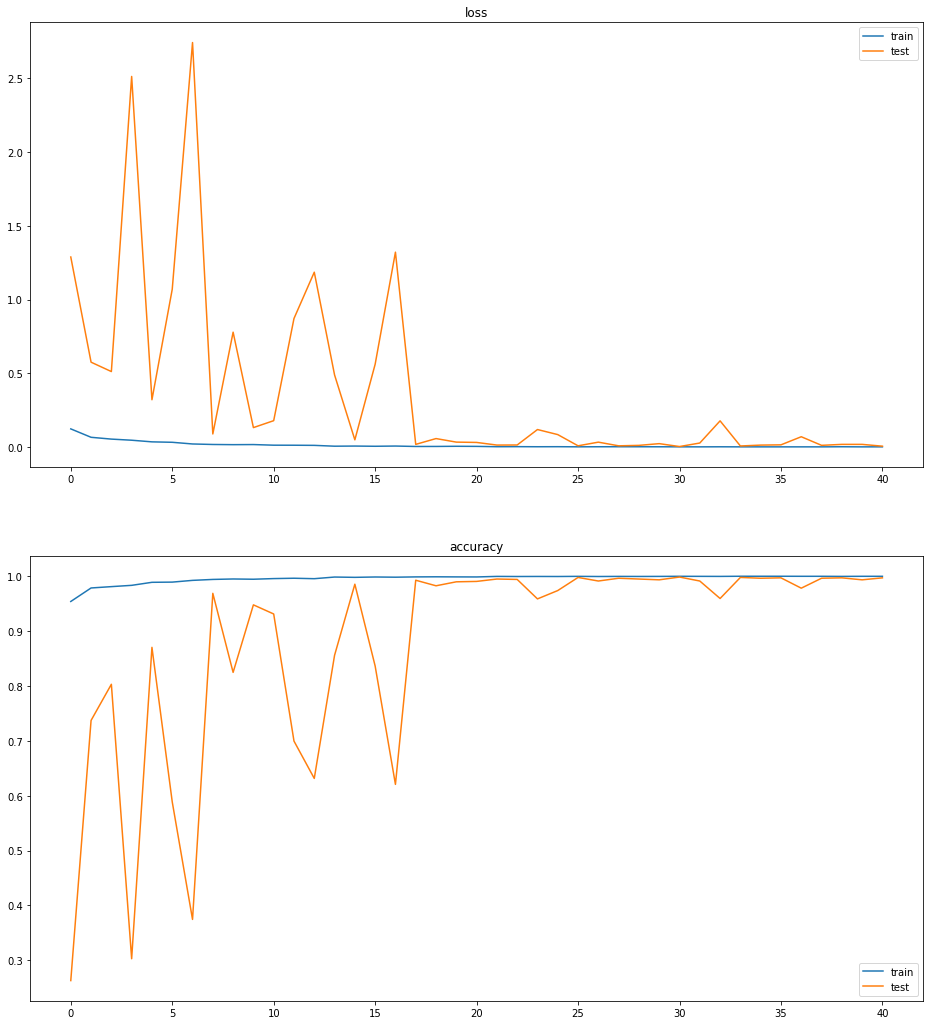

In [ ]:
plt.figure(1, figsize=(16,18))
plt.subplot(2,1,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['train','val'])
plt.title('loss')
plt.subplot(2,1,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['train','val'])
plt.title('accuracy')
plt.show()

In [ ]:
loss, acc, pre, rec = model.evaluate(test_generator)
print("\ntest %s: %.2f%%" % (resnet152_model.metrics_names[1], acc * 100))
print("\ntest %s: %.2f%%" % (resnet152_model.metrics_names[2], pre * 100))
print("\ntest %s: %.2f%%" % (resnet152_model.metrics_names[3], rec * 100))

44/44 [==============================] - 15s 342ms/step - loss: 0.0256 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942

test accuracy: 99.42%

test precision_2: 99.42%

test recall_2: 99.42%
